# Raster Analysis

This is additional supplementary to the original report. I have saved this code here because of the large amount of RAM required to run this. Please try not to run this as, by experience, it would take more than 2 hours to run.

In [1]:
import re, functools
from glob import glob
import rasterio as rs
from rasterio.plot import show, show_hist
import rasterstats as rstats
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
states_geojson = gp.read_file("https://datahub.io/core/geo-ne-admin1/r/admin1.geojson")
countries_geojson.to_file("data/country/world_locations.json", driver='GeoJSON')
countries_geojson

,ISO3166-1-Alpha-3,country,id,name,geometry
0,ABW,Aruba,5150,Aruba,"POLYGON ((-69.99694 12.57758, -69.93639 12.531..."
1,AFG,Afghanistan,1741,Badghis,"POLYGON ((64.30624 35.39722, 64.32468 35.40177..."
2,AFG,Afghanistan,1742,Hirat,"POLYGON ((61.36393 35.59824, 61.36548 35.59850..."
3,AFG,Afghanistan,1743,Bamyan,"POLYGON ((67.74391 35.44342, 67.75476 35.44412..."
4,AFG,Afghanistan,1744,Balkh,"POLYGON ((67.25913 37.18515, 67.28145 37.18866..."
...,...,...,...,...,...
4642,ZWE,Zimbabwe,529,Manicaland,"POLYGON ((33.01165 -17.38399, 32.99745 -17.404..."
4643,ZWE,Zimbabwe,530,Matabeleland South,"POLYGON ((29.43994 -19.87930, 29.45699 -19.874..."
4644,ZWE,Zimbabwe,531,Bulawayo,"POLYGON ((28.49757 -20.06270, 28.50532 -20.062..."
4645,ZWE,Zimbabwe,532,Masvingo,"POLYGON ((31.04181 -19.25226, 31.19870 -19.248..."


In [2]:
countries_geojson = gp.read_file("data/country/world_countries.json")
countries_geojson

,Country,ISO_A3,geometry
0,Aruba,ABW,"POLYGON ((-69.99694 12.57758, -69.93639 12.531..."
1,Afghanistan,AFG,"POLYGON ((71.04980 38.40866, 71.05714 38.40903..."
2,Angola,AGO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -..."
3,Anguilla,AIA,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ..."
4,Albania,ALB,"POLYGON ((19.74777 42.57890, 19.74601 42.57993..."
...,...,...,...
250,Samoa,WSM,"MULTIPOLYGON (((-171.57002 -13.93816, -171.564..."
251,Yemen,YEM,"MULTIPOLYGON (((53.30824 12.11839, 53.31027 12..."
252,South Africa,ZAF,"MULTIPOLYGON (((37.86378 -46.94085, 37.83644 -..."
253,Zambia,ZMB,"POLYGON ((31.11984 -8.61663, 31.14102 -8.60619..."


In [3]:
states_geojson = gp.read_file("data/country/world_locations.json")
states_geojson

,ISO3166-1-Alpha-3,country,id,name,geometry
0,ABW,Aruba,5150,Aruba,"POLYGON ((-69.99694 12.57758, -69.93639 12.531..."
1,AFG,Afghanistan,1741,Badghis,"POLYGON ((64.30624 35.39722, 64.32468 35.40177..."
2,AFG,Afghanistan,1742,Hirat,"POLYGON ((61.36393 35.59824, 61.36548 35.59850..."
3,AFG,Afghanistan,1743,Bamyan,"POLYGON ((67.74391 35.44342, 67.75476 35.44412..."
4,AFG,Afghanistan,1744,Balkh,"POLYGON ((67.25913 37.18515, 67.28145 37.18866..."
...,...,...,...,...,...
4642,ZWE,Zimbabwe,529,Manicaland,"POLYGON ((33.01165 -17.38399, 32.99745 -17.404..."
4643,ZWE,Zimbabwe,530,Matabeleland South,"POLYGON ((29.43994 -19.87930, 29.45699 -19.874..."
4644,ZWE,Zimbabwe,531,Bulawayo,"POLYGON ((28.49757 -20.06270, 28.50532 -20.062..."
4645,ZWE,Zimbabwe,532,Masvingo,"POLYGON ((31.04181 -19.25226, 31.19870 -19.248..."


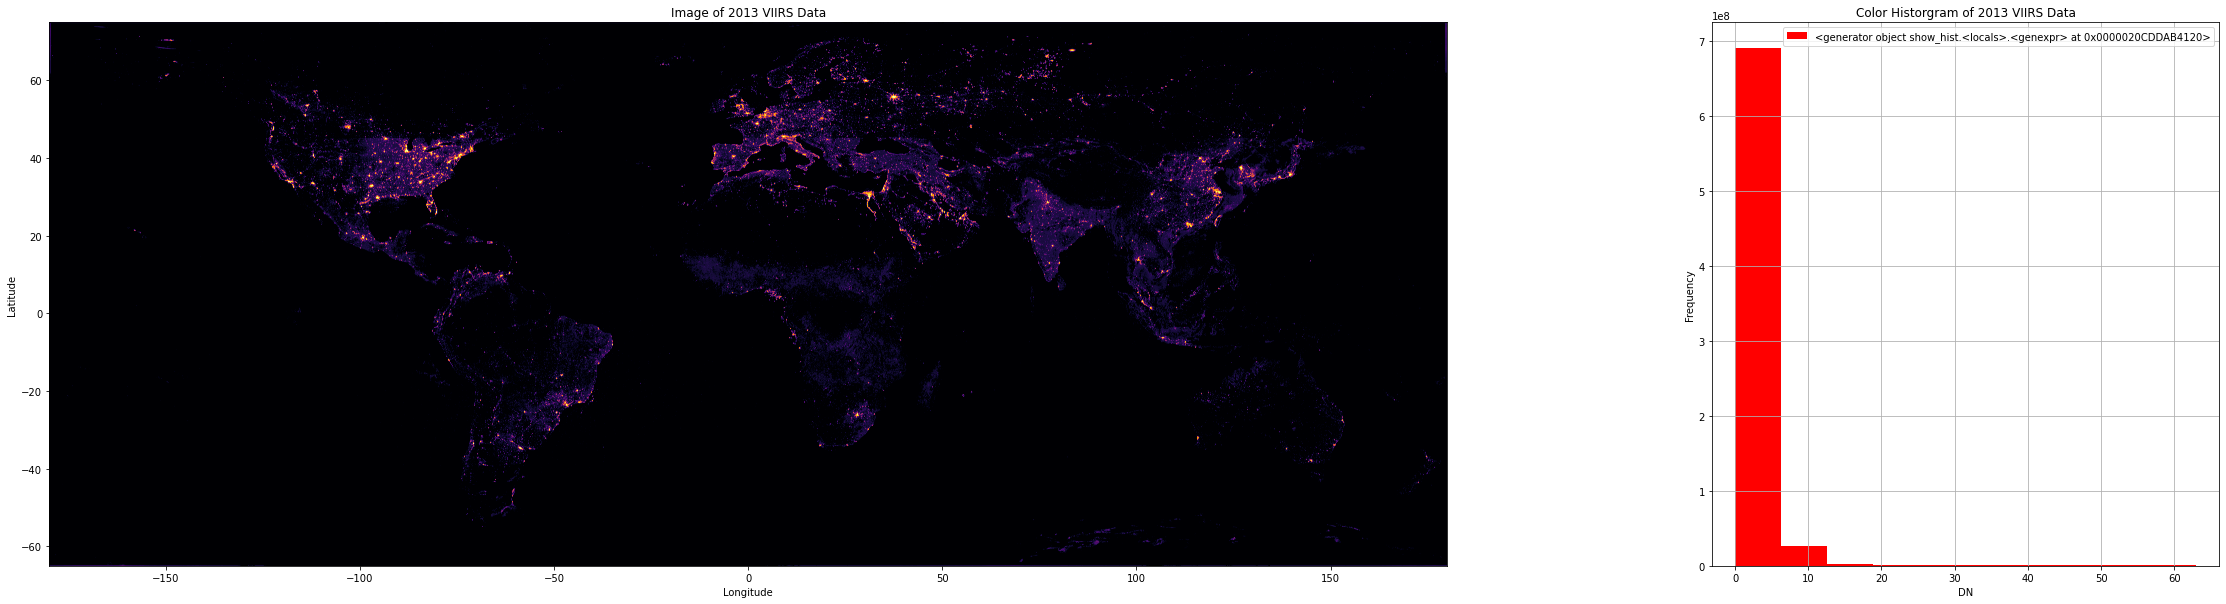

In [9]:
fig, (axim, axhist) = plt.subplots(1, 2, figsize=(40, 10), gridspec_kw={'width_ratios': [3, 1]})
rf = rs.open("data/nightLight/DN_NTL_2013_simVIIRS.tif", "r")
show(rf, ax=axim, cmap="inferno")
show_hist(rf, ax=axhist)
axim.set(xlabel="Longitude", ylabel="Latitude", title="Image of 2013 VIIRS Data")
axhist.set_title("Color Historgram of 2013 VIIRS Data")
del rf

In [10]:
def retrieveGeoStats(raster_file, geojson=states_geojson, nodata=64):
    year = re.search(r"\d+", raster_file).group()
    print(f"Processing {year}...")
    rf = rs.open(raster_file,"r")
    values = pd.DataFrame(rstats.zonal_stats(geojson, rf.read(1), affine=rf.transform, stats=["count", "mean", "min", "max", 'median', 'std', "majority"], geojson_out=True, nodata=nodata))
    del rf
    return pd.concat([values, values.properties.apply(pd.Series)], axis=1).drop(columns=["id", "type", "properties", "bbox", "ISO3166-1-Alpha-3", "geometry"]).rename(columns={"majority": "mode"}).fillna(0)

nightLight2013 = retrieveGeoStats(raster_file = "data/nightLight/DN_NTL_2013_simVIIRS.tif")
nightLight2013

Processing 2013...


,country,name,min,max,mean,count,std,median,mode
0,Aruba,Aruba,7.0,57.0,28.666667,201,16.178831,28.0,7.0
1,Afghanistan,Badghis,0.0,32.0,0.236040,29334,1.336606,0.0,0.0
2,Afghanistan,Hirat,0.0,56.0,0.741159,78071,2.932197,0.0,0.0
3,Afghanistan,Bamyan,0.0,8.0,0.180535,25153,1.039803,0.0,0.0
4,Afghanistan,Balkh,0.0,61.0,2.011429,23275,5.675208,0.0,0.0
...,...,...,...,...,...,...,...,...,...
4642,Zimbabwe,Manicaland,0.0,46.0,1.915220,42982,3.263857,0.0,0.0
4643,Zimbabwe,Matabeleland South,0.0,52.0,0.677659,68170,2.175918,0.0,0.0
4644,Zimbabwe,Bulawayo,0.0,55.0,21.061511,569,15.322821,14.0,7.0
4645,Zimbabwe,Masvingo,0.0,26.0,0.701861,69850,2.066331,0.0,0.0


In [11]:
nightLight2013.to_csv("data/nightLight/nightLight2013.csv", index=False)
del nightLight2013

In [6]:
for raster_file in glob("data/nightLight/Harmonized*.tif"):
    year = re.search(r"\d+", raster_file).group()
    nightLightTemp = retrieveGeoStats(raster_file)
    nightLightTemp.to_csv(f"data/nightLight/harmonizedNightLight{year}.csv", index=False)
    del nightLightTemp


Processing 1992...
Processing 1993...
Processing 1994...
Processing 1995...
Processing 1996...
Processing 1997...
Processing 1998...
Processing 1999...
Processing 2000...
Processing 2001...
Processing 2002...
Processing 2003...
Processing 2004...
Processing 2005...
Processing 2006...
Processing 2007...
Processing 2008...
Processing 2009...
Processing 2010...
Processing 2011...
Processing 2012...
Processing 2013...
Processing 2014...
Processing 2015...
Processing 2016...
Processing 2017...
Processing 2018...


In [12]:
for raster_file in glob("data/nightLight/Harmonized*.tif"):
    year = re.search(r"\d+", raster_file).group()
    nightLightTemp = retrieveGeoStats(raster_file, nodata=0)
    nightLightTemp.to_csv(f"data/nightLight/harmonizedNightLightNoData{year}.csv", index=False)
    del nightLightTemp
print("Processing Completed!")

Processing 1992...
Processing 1993...
Processing 1994...
Processing 1995...
Processing 1996...
Processing 1997...
Processing 1998...
Processing 1999...
Processing 2000...
Processing 2001...
Processing 2002...
Processing 2003...
Processing 2004...
Processing 2005...
Processing 2006...
Processing 2007...
Processing 2008...
Processing 2009...
Processing 2010...
Processing 2011...
Processing 2012...
Processing 2013...
Processing 2014...
Processing 2015...
Processing 2016...
Processing 2017...
Processing 2018...
Processing Completed!


In [5]:
def retrieveGeoStats(raster_file, geojson=countries_geojson, nodata=64):
    year = re.search(r"\d+", raster_file).group()
    print(f"Processing {year}...")
    rf = rs.open(raster_file,"r")
    values = pd.DataFrame(rstats.zonal_stats(geojson, rf.read(1), affine=rf.transform, stats=["count", "mean", "min", "max", 'median', 'std', "majority"], geojson_out=True, nodata=nodata))
    del rf
    return pd.concat([values, values.properties.apply(pd.Series)], axis=1).drop(columns=["id", "type", "properties", "bbox", "ISO_A3", "geometry"]).rename(columns={"majority": "mode"}).fillna(0).set_index("Country").rename(columns=lambda x: x+" "+year)

nightLightIndiv = [retrieveGeoStats(raster_file, countries_geojson) for raster_file in glob("data/nightLight/Harmonized*.tif")]
nightLight = functools.reduce(pd.DataFrame.join, nightLightIndiv).stack().reset_index()
nightLight

Processing 1992...
Processing 1993...
Processing 1994...
Processing 1995...
Processing 1996...
Processing 1997...
Processing 1998...
Processing 1999...
Processing 2000...
Processing 2001...
Processing 2002...
Processing 2003...
Processing 2004...
Processing 2005...
Processing 2006...
Processing 2007...
Processing 2008...
Processing 2009...
Processing 2010...
Processing 2011...
Processing 2012...
Processing 2013...
Processing 2014...
Processing 2015...
Processing 2016...
Processing 2017...
Processing 2018...


,Country,level_1,0
0,Aruba,min 1992,5.000000
1,Aruba,max 1992,63.000000
2,Aruba,mean 1992,30.731343
3,Aruba,count 1992,201.000000
4,Aruba,std 1992,18.759739
...,...,...,...
48190,Zimbabwe,mean 2018,2.009717
48191,Zimbabwe,count 2018,481200.000000
48192,Zimbabwe,std 2018,3.633314
48193,Zimbabwe,median 2018,0.000000


In [48]:
nightLight = functools.reduce(pd.DataFrame.join, nightLightIndiv).stack().reset_index()
nightLight.loc[:, ["Quantity", "Year"]] = nightLight.level_1.str.split().apply(pd.Series).rename(columns={0:"Quantity", 1:"Year"})
nightLightCSV = nightLight.rename(columns={0: "Value"}).drop(columns="level_1").set_index(["Year", "Quantity", "Country"]).unstack()["Value"]
nightLightCSV

Country          Afghanistan  Akrotiri Sovereign Base Area        Aland  \
Year Quantity                                                             
1992 count     901332.000000                    137.000000  2190.000000   
     max           59.000000                     39.000000    53.000000   
     mean           0.027943                     14.912409     2.225571   
     median         0.000000                     14.000000     0.000000   
     min            0.000000                      0.000000     0.000000   
...                      ...                           ...          ...   
2018 mean           2.047282                     34.408759     4.557534   
     median         0.000000                     34.000000     0.000000   
     min            0.000000                      9.000000     0.000000   
     mode           0.000000                     51.000000     0.000000   
     std            3.555359                     14.801142    10.894895   

Country             Albania       Algeria  American Samoa     Andorra  \
Year Quantity                                                           
1992 count     43766.000000  3.062687e+06      216.000000  711.000000   
     max          39.000000  6.300000e+01       32.000000   63.000000   
     mean          0.264269  5.061918e-01        9.685185   15.614627   
     median        0.000000  0.000000e+00        8.000000    9.000000   
     min           0.000000  0.000000e+00        0.000000    0.000000   
...                     ...           ...             ...         ...   
2018 mean          8.770347  2.811383e+00       18.037037   24.846695   
     median        7.000000  0.000000e+00       13.500000   19.000000   
     min           0.000000  0.000000e+00        0.000000    7.000000   
     mode          7.000000  0.000000e+00        7.000000    8.000000   
     std           7.885158  6.959879e+00       11.895320   17.029646   

Country              Angola    Anguilla    Antarctica  ...     Uzbekistan  \
Year Quantity                                          ...                  
1992 count     1.491515e+06  100.000000  73912.000000  ...  698379.000000   
     max       6.300000e+01   21.000000      8.000000  ...      63.000000   
     mean      3.853196e-02    9.650000      0.004127  ...       1.726949   
     median    0.000000e+00    9.000000      0.000000  ...       0.000000   
     min       0.000000e+00    0.000000      0.000000  ...       0.000000   
...                     ...         ...           ...  ...            ...   
2018 mean      1.631923e+00   15.900000      0.621469  ...       3.258340   
     median    0.000000e+00   14.000000      0.000000  ...       0.000000   
     min       0.000000e+00    0.000000      0.000000  ...       0.000000   
     mode      0.000000e+00   11.000000      0.000000  ...       0.000000   
     std       3.834231e+00    7.139328      1.978841  ...       5.914810   

Country             Vanuatu  Vatican City     Venezuela        Vietnam  \
Year Quantity                                                            
1992 count     14990.000000           0.0  1.076792e+06  402417.000000   
     max          33.000000           0.0  6.300000e+01      63.000000   
     mean          0.148032           0.0  1.132978e+00       0.428158   
     median        0.000000           0.0  0.000000e+00       0.000000   
     min           0.000000           0.0  0.000000e+00       0.000000   
...                     ...           ...           ...            ...   
2018 mean          1.618412           0.0  4.400938e+00       8.588959   
     median        0.000000           0.0  0.000000e+00       7.000000   
     min           0.000000           0.0  0.000000e+00       0.000000   
     mode          0.000000           0.0  0.000000e+00       7.000000   
     std           6.371589           0.0  7.879986e+00      10.506223   

Country        Wallis and Futuna  Western Sahara          Yemen  \
Year Quantity                             

In [49]:
nightLightCSV.to_csv("data/nightLight/nightLight.csv")
del nightLightCSV
del nightLight

In [50]:
pd.read_csv("data/nightLight/nightLight.csv")

,Year,Quantity,Afghanistan,Akrotiri Sovereign Base Area,Aland,Albania,Algeria,American Samoa,Andorra,Angola,...,Uzbekistan,Vanuatu,Vatican City,Venezuela,Vietnam,Wallis and Futuna,Western Sahara,Yemen,Zambia,Zimbabwe
0,1992,count,901332.000000,137.000000,2190.000000,43766.000000,3.062687e+06,216.000000,711.000000,1.491515e+06,...,698379.000000,14990.000000,0.0,1.076792e+06,402417.000000,166.000000,116159.000000,550751.000000,904610.000000,481200.000000
1,1992,max,59.000000,39.000000,53.000000,39.000000,6.300000e+01,32.000000,63.000000,6.300000e+01,...,63.000000,33.000000,0.0,6.300000e+01,63.000000,5.000000,19.000000,63.000000,63.000000,63.000000
2,1992,mean,0.027943,14.912409,2.225571,0.264269,5.061918e-01,9.685185,15.614627,3.853196e-02,...,1.726949,0.148032,0.0,1.132978e+00,0.428158,0.614458,0.002961,0.290173,0.086135,0.237517
3,1992,median,0.000000,14.000000,0.000000,0.000000,0.000000e+00,8.000000,9.000000,0.000000e+00,...,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1992,min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,2018,mean,2.047282,34.408759,4.557534,8.770347,2.811383e+00,18.037037,24.846695,1.631923e+00,...,3.258340,1.618412,0.0,4.400938e+00,8.588959,5.855422,0.053453,1.301654,3.077475,2.009717
185,2018,median,0.000000,34.000000,0.000000,7.000000,0.000000e+00,13.500000,19.000000,0.000000e+00,...,0.000000,0.000000,0.0,0.000000e+00,7.000000,6.000000,0.000000,0.000000,0.000000,0.000000
186,2018,min,0.000000,9.000000,0.000000,0.000000,0.000000e+00,0.000000,7.000000,0.000000e+00,...,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
187,2018,mode,0.000000,51.000000,0.000000,7.000000,0.000000e+00,7.000000,8.000000,0.000000e+00,...,0.000000,0.000000,0.0,0.000000e+00,7.000000,6.000000,0.000000,0.000000,0.000000,0.000000


In [34]:
nightLightNoDarkIndiv = [retrieveGeoStats(raster_file, countries_geojson, 0) for raster_file in glob("data/nightLight/Harmonized*.tif")]
nightLightNoDark = functools.reduce(pd.DataFrame.join, nightLightNoDarkIndiv).stack().reset_index()
nightLightNoDark

Processing 1992...
Processing 1993...
Processing 1994...
Processing 1995...
Processing 1996...
Processing 1997...
Processing 1998...
Processing 1999...
Processing 2000...
Processing 2001...
Processing 2002...
Processing 2003...
Processing 2004...
Processing 2005...
Processing 2006...
Processing 2007...
Processing 2008...
Processing 2009...
Processing 2010...
Processing 2011...
Processing 2012...
Processing 2013...
Processing 2014...
Processing 2015...
Processing 2016...
Processing 2017...
Processing 2018...


,Country,level_1,0
0,Aruba,min 1992,5.000000
1,Aruba,max 1992,63.000000
2,Aruba,mean 1992,30.731343
3,Aruba,count 1992,201.000000
4,Aruba,std 1992,18.759739
...,...,...,...
48190,Zimbabwe,mean 2018,6.837552
48191,Zimbabwe,count 2018,141436.000000
48192,Zimbabwe,std 2018,3.449983
48193,Zimbabwe,median 2018,6.000000


In [51]:
nightLightNoDark = functools.reduce(pd.DataFrame.join, nightLightNoDarkIndiv).stack().reset_index()
nightLightNoDark.loc[:, ["Quantity", "Year"]] = nightLightNoDark.level_1.str.split().apply(pd.Series).rename(columns={0:"Quantity", 1:"Year"})
nightLightNoDarkCSV = nightLightNoDark.rename(columns={0: "Value"}).drop(columns="level_1").set_index(["Year", "Quantity", "Country"]).unstack()["Value"]
nightLightNoDarkCSV

Country        Afghanistan  Akrotiri Sovereign Base Area       Aland  \
Year Quantity                                                          
1992 count     2088.000000                    135.000000  266.000000   
     max         59.000000                     39.000000   53.000000   
     mean        12.062261                     15.133333   18.323308   
     median       7.000000                     14.000000   13.000000   
     min          3.000000                      4.000000    7.000000   
...                    ...                           ...         ...   
2018 mean         6.765070                     34.408759   12.460674   
     median       6.000000                     34.000000    7.000000   
     min          6.000000                      9.000000    6.000000   
     mode         6.000000                     51.000000    6.000000   
     std          3.139037                     14.801142   15.035082   

Country            Albania        Algeria  American Samoa     Andorra  \
Year Quantity                                                           
1992 count     1481.000000  143436.000000      156.000000  626.000000   
     max         39.000000      63.000000       32.000000   63.000000   
     mean         7.809588      10.808354       13.410256   17.734824   
     median       6.000000       6.000000       13.000000   11.000000   
     min          4.000000       3.000000        3.000000    4.000000   
...                    ...            ...             ...         ...   
2018 mean         9.207076      10.239452       18.377358   24.846695   
     median       7.000000       7.000000       14.000000   19.000000   
     min          6.000000       6.000000        6.000000    7.000000   
     mode         7.000000       7.000000        7.000000    8.000000   
     std          7.826291      10.018264       11.743688   17.029646   

Country             Angola   Anguilla  Antarctica  ...    Uzbekistan  \
Year Quantity                                      ...                 
1992 count     5237.000000  94.000000   60.000000  ...  94961.000000   
     max         63.000000  21.000000    8.000000  ...     63.000000   
     mean        10.974031  10.265957    5.083333  ...     12.700635   
     median       7.000000   9.000000    5.000000  ...      9.000000   
     min          3.000000   4.000000    4.000000  ...      3.000000   
...                    ...        ...         ...  ...           ...   
2018 mean         7.011606  16.060606    6.910486  ...      8.777289   
     median       6.000000  14.000000    7.000000  ...      7.000000   
     min          6.000000   7.000000    6.000000  ...      6.000000   
     mode         6.000000  11.000000    7.000000  ...      7.000000   
     std          5.044252   6.993241    0.286536  ...      6.767632   

Country           Vanuatu  Vatican City     Venezuela       Vietnam  \
Year Quantity                                                         
1992 count     240.000000           0.0  86842.000000  26758.000000   
     max        33.000000           0.0     63.000000     63.000000   
     mean        9.245833           0.0     14.048295      6.439121   
     median      6.000000           0.0      8.000000      5.000000   
     min         4.000000           0.0      3.000000      2.000000   
...                   ...           ...           ...           ...   
2018 mean       11.546882           0.0      9.268471     10.850339   
     median      7.000000           0.0      7.000000      7.000000   
     min         6.000000           0.0      6.000000      6.000000   
     mode        6.000000           0.0      6.000000      7.000000   
     std        13.228966           0.0      9.255113     10.719424   

Country        Wallis and Futuna  Western Sahara         Yemen       Zambia  \
Year Quantity                                                                 
1992 count             24.000000       61.000000  19512.000000  6528.000000   
     max       

In [52]:
nightLightNoDarkCSV.to_csv("data/nightLight/nightLightNoDark.csv")
del nightLightNoDarkCSV
del nightLightNoDark

In [53]:
pd.read_csv("data/nightLight/nightLightNoDark.csv")

,Year,Quantity,Afghanistan,Akrotiri Sovereign Base Area,Aland,Albania,Algeria,American Samoa,Andorra,Angola,...,Uzbekistan,Vanuatu,Vatican City,Venezuela,Vietnam,Wallis and Futuna,Western Sahara,Yemen,Zambia,Zimbabwe
0,1992,count,2088.000000,135.000000,266.000000,1481.000000,143436.000000,156.000000,626.000000,5237.000000,...,94961.000000,240.000000,0.0,86842.000000,26758.000000,24.000000,61.000000,19512.000000,6528.000000,10854.000000
1,1992,max,59.000000,39.000000,53.000000,39.000000,63.000000,32.000000,63.000000,63.000000,...,63.000000,33.000000,0.0,63.000000,63.000000,5.000000,19.000000,63.000000,63.000000,63.000000
2,1992,mean,12.062261,15.133333,18.323308,7.809588,10.808354,13.410256,17.734824,10.974031,...,12.700635,9.245833,0.0,14.048295,6.439121,4.250000,5.639344,8.190498,11.936121,10.530035
3,1992,median,7.000000,14.000000,13.000000,6.000000,6.000000,13.000000,11.000000,7.000000,...,9.000000,6.000000,0.0,8.000000,5.000000,4.000000,5.000000,5.000000,7.000000,5.000000
4,1992,min,3.000000,4.000000,7.000000,4.000000,3.000000,3.000000,4.000000,3.000000,...,3.000000,4.000000,0.0,3.000000,2.000000,3.000000,4.000000,3.000000,3.000000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,2018,mean,6.765070,34.408759,12.460674,9.207076,10.239452,18.377358,24.846695,7.011606,...,8.777289,11.546882,0.0,9.268471,10.850339,6.352941,6.612354,8.261827,6.739344,6.837552
185,2018,median,6.000000,34.000000,7.000000,7.000000,7.000000,14.000000,19.000000,6.000000,...,7.000000,7.000000,0.0,7.000000,7.000000,6.000000,6.000000,6.000000,6.000000,6.000000
186,2018,min,6.000000,9.000000,6.000000,6.000000,6.000000,6.000000,7.000000,6.000000,...,6.000000,6.000000,0.0,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
187,2018,mode,6.000000,51.000000,6.000000,7.000000,7.000000,7.000000,8.000000,6.000000,...,7.000000,6.000000,0.0,6.000000,7.000000,6.000000,6.000000,6.000000,6.000000,6.000000
